If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses the keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Define the game environment and replay classes

In [2]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




## Creating Snake Enviorment

In [3]:
class Snake(object):
    def __init__(self, grid_size = 45, max_moves_multiplyer = 1):
        self.max_moves = (grid_size**2) *  max_moves_multiplyer
        self.grid_size = grid_size
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]
    
    def _update_state(self, action):
        [fruit_x, fruit_y], snake, [move] = self.state
        
        direction = [snake[0][0] - snake[1][0], snake[0][1] - snake[1][1]]
        if action == 0:
            movement = direction # Forward
        elif action == 1:
            movement = [-1*direction[1], direction[0]] # Right
        elif action == 2:
            movement = [direction[1], -1*direction[0]] # Down
        else:
            raise Exception('Invalid action {}'.format(action))
        
        snake_new = [np.add(snake[0], movement).tolist()] + snake
        
        if [fruit_x, fruit_y] not in snake_new:
            snake_new = snake_new[:-1]
        
        #print("Snake: {}".format(snake))
        self.state = [[fruit_x, fruit_y], snake_new, [move + 1]]
        
    def _draw_state(self):
        
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        [fruit_x, fruit_y], snake, [move] = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        for coord in snake:
            try:
                canvas[coord[1]][coord[0]] = 1  # draw snake
            except IndexError:
                canvas = np.zeros(im_size)
                #print('dead')
                break
        return canvas
        
    def _get_reward(self):
        
        [fruit_x, fruit_y], snake, [move] = self.state
        if snake[0] in snake[1:]:
            #print("ouch")
            return -1 # it hit itself
        if snake[0][0] < 0 or snake[0][0] > self.grid_size - 1 or snake[0][1] < 0 or snake[0][1] > self.grid_size - 1:
            return -1 # it hit a wall
        if [fruit_x, fruit_y] in snake:
            #print("got fruit?")
            while [fruit_x, fruit_y] in snake: # reseting fruit probably, need a better way if the snake gets good.
                fruit_x = np.random.randint(0, grid_size)
                fruit_y = np.random.randint(0, grid_size)
            self.state[0] = [fruit_x, fruit_y]
            self.state[2] = [0]
            return 1 # it ate the fruit
        if move > (self.max_moves) + (len(snake)):
            return -1 # ran out of time
#         if (fruit_x - snake[0][0])**2 + (fruit_y - snake[0][1])**2 < (fruit_x - snake[1][0])**2 + (fruit_y - snake[1][1])**2:
#             return 1
        else:
            return 0 # the fruit is still on the board
    
    def observe(self):
        
        canvas = self._draw_state()
        return canvas.reshape((1, -1))
    
    def act(self, action):
        
        self._update_state(action)
        reward = self._get_reward()
        if reward != -1:
            observation = self.observe()
        else:
            [fruit_x, fruit_y], snake, [move] = self.state
            self.state = [[fruit_x, fruit_y], snake[1:], [move]] # removing head bc if it goes out of bounds then the observe does not work.
            observation = self.observe()
        
        game_over = (reward < 0) # if the reward is -1 then the snake died
        return observation, reward, game_over
    
    def reset(self):
        
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]

##  Functions for creating, training, and visualizing the model

In [16]:
# parameters
epsilon = .4  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # Define environment/game
    env = Snake(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    total = 0
    for episode in range(num_episodes):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()
        
        catch_count = 0

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)
            if reward == 1:
                catch_count += 1

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            # get data updated based on the stored experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on the updated data
            loss += model.train_on_batch(inputs, targets)

            starting_observation = new_observation # for next time through the loop
        
        total += catch_count
        avg = total/(episode + 1)

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Catch count {} | Average {} ".format(episode, num_episodes-1, loss, catch_count, avg))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    
    observations = []
    for _ in range(num_games):
        print("game start")
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
#             action = np.random.randint(0,4)
#             action = 1
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            #print("move")
            print(reward)
        print("game end")
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [17]:
model, env, exp_replay = build_model()

game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end


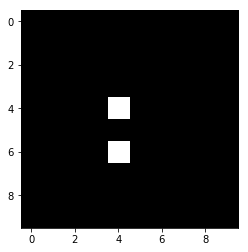

In [6]:
animation = create_animation(model, env, num_games=3)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episode 0000/0999 | Loss 0.1092 | Catch count 0 | Average 0.0 
Episode 0001/0999 | Loss 0.3392 | Catch count 1 | Average 0.5 
Episode 0002/0999 | Loss 0.1649 | Catch count 0 | Average 0.3333333333333333 
Episode 0003/0999 | Loss 0.5163 | Catch count 0 | Average 0.25 
Episode 0004/0999 | Loss 0.0778 | Catch count 0 | Average 0.2 
Episode 0005/0999 | Loss 0.1164 | Catch count 0 | Average 0.16666666666666666 
Episode 0006/0999 | Loss 0.0967 | Catch count 0 | Average 0.14285714285714285 
Episode 0007/0999 | Loss 0.1998 | Catch count 1 | Average 0.25 
Episode 0008/0999 | Loss 0.4053 | Catch count 1 | Average 0.3333333333333333 
Episode 0009/0999 | Loss 0.0671 | Catch count 0 | Average 0.3 
Episode 0010/0999 | Loss 0.5755 | Catch count 1 | Average 0.36363636363636365 
Episode 0011/0999 | Loss 0.0710 | Catch count 0 | Average 0.3333333333333333 
Episode 0012/0999 | Loss 0.2977 | Catch count 0 | Average 0.3076923076923077 
Episode 0013/0999 | Loss 0.2344 | Catch count 1 | Average 0.35714285714

Episode 0109/0999 | Loss 0.1931 | Catch count 0 | Average 0.2545454545454545 
Episode 0110/0999 | Loss 0.2000 | Catch count 0 | Average 0.25225225225225223 
Episode 0111/0999 | Loss 0.1637 | Catch count 0 | Average 0.25 
Episode 0112/0999 | Loss 0.3258 | Catch count 1 | Average 0.25663716814159293 
Episode 0113/0999 | Loss 0.9260 | Catch count 0 | Average 0.2543859649122807 
Episode 0114/0999 | Loss 0.1463 | Catch count 0 | Average 0.25217391304347825 
Episode 0115/0999 | Loss 0.0784 | Catch count 0 | Average 0.25 
Episode 0116/0999 | Loss 0.1551 | Catch count 0 | Average 0.24786324786324787 
Episode 0117/0999 | Loss 0.8200 | Catch count 0 | Average 0.2457627118644068 
Episode 0118/0999 | Loss 0.1418 | Catch count 0 | Average 0.24369747899159663 
Episode 0119/0999 | Loss 0.1687 | Catch count 1 | Average 0.25 
Episode 0120/0999 | Loss 0.1672 | Catch count 0 | Average 0.24793388429752067 
Episode 0121/0999 | Loss 0.2132 | Catch count 0 | Average 0.2459016393442623 
Episode 0122/0999 | Lo

Episode 0216/0999 | Loss 0.2473 | Catch count 0 | Average 0.22119815668202766 
Episode 0217/0999 | Loss 0.1216 | Catch count 1 | Average 0.22477064220183487 
Episode 0218/0999 | Loss 0.1237 | Catch count 0 | Average 0.2237442922374429 
Episode 0219/0999 | Loss 0.0568 | Catch count 0 | Average 0.22272727272727272 
Episode 0220/0999 | Loss 0.6912 | Catch count 1 | Average 0.22624434389140272 
Episode 0221/0999 | Loss 0.7652 | Catch count 0 | Average 0.22522522522522523 
Episode 0222/0999 | Loss 0.2001 | Catch count 1 | Average 0.22869955156950672 
Episode 0223/0999 | Loss 0.1081 | Catch count 0 | Average 0.22767857142857142 
Episode 0224/0999 | Loss 0.0993 | Catch count 0 | Average 0.22666666666666666 
Episode 0225/0999 | Loss 0.1460 | Catch count 1 | Average 0.23008849557522124 
Episode 0226/0999 | Loss 0.1962 | Catch count 0 | Average 0.2290748898678414 
Episode 0227/0999 | Loss 0.2060 | Catch count 0 | Average 0.22807017543859648 
Episode 0228/0999 | Loss 0.3317 | Catch count 0 | Aver

Episode 0321/0999 | Loss 0.3550 | Catch count 0 | Average 0.2484472049689441 
Episode 0322/0999 | Loss 0.1403 | Catch count 0 | Average 0.2476780185758514 
Episode 0323/0999 | Loss 0.5805 | Catch count 2 | Average 0.25308641975308643 
Episode 0324/0999 | Loss 0.2034 | Catch count 0 | Average 0.2523076923076923 
Episode 0325/0999 | Loss 0.3620 | Catch count 0 | Average 0.25153374233128833 
Episode 0326/0999 | Loss 0.2814 | Catch count 0 | Average 0.25076452599388377 
Episode 0327/0999 | Loss 0.1715 | Catch count 0 | Average 0.25 
Episode 0328/0999 | Loss 0.3797 | Catch count 0 | Average 0.24924012158054712 
Episode 0329/0999 | Loss 0.7512 | Catch count 2 | Average 0.2545454545454545 
Episode 0330/0999 | Loss 0.1163 | Catch count 0 | Average 0.2537764350453172 
Episode 0331/0999 | Loss 0.2631 | Catch count 0 | Average 0.25301204819277107 
Episode 0332/0999 | Loss 0.2727 | Catch count 3 | Average 0.26126126126126126 
Episode 0333/0999 | Loss 0.1372 | Catch count 0 | Average 0.260479041916

Episode 0426/0999 | Loss 0.4310 | Catch count 0 | Average 0.2646370023419204 
Episode 0427/0999 | Loss 0.0427 | Catch count 0 | Average 0.26401869158878505 
Episode 0428/0999 | Loss 0.1865 | Catch count 0 | Average 0.2634032634032634 
Episode 0429/0999 | Loss 0.0840 | Catch count 0 | Average 0.2627906976744186 
Episode 0430/0999 | Loss 0.0271 | Catch count 0 | Average 0.26218097447795824 
Episode 0431/0999 | Loss 0.4042 | Catch count 0 | Average 0.26157407407407407 
Episode 0432/0999 | Loss 0.0380 | Catch count 0 | Average 0.26096997690531176 
Episode 0433/0999 | Loss 0.0301 | Catch count 0 | Average 0.26036866359447003 
Episode 0434/0999 | Loss 0.1395 | Catch count 0 | Average 0.2597701149425287 
Episode 0435/0999 | Loss 0.1593 | Catch count 0 | Average 0.2591743119266055 
Episode 0436/0999 | Loss 0.1097 | Catch count 0 | Average 0.2585812356979405 
Episode 0437/0999 | Loss 0.1392 | Catch count 0 | Average 0.2579908675799087 
Episode 0438/0999 | Loss 0.0778 | Catch count 0 | Average 0

Episode 0533/0999 | Loss 0.0588 | Catch count 0 | Average 0.250936329588015 
Episode 0534/0999 | Loss 0.3367 | Catch count 1 | Average 0.2523364485981308 
Episode 0535/0999 | Loss 0.2794 | Catch count 0 | Average 0.251865671641791 
Episode 0536/0999 | Loss 0.3500 | Catch count 0 | Average 0.25139664804469275 
Episode 0537/0999 | Loss 0.1658 | Catch count 0 | Average 0.25092936802973975 
Episode 0538/0999 | Loss 0.1225 | Catch count 0 | Average 0.2504638218923933 
Episode 0539/0999 | Loss 0.0854 | Catch count 0 | Average 0.25 
Episode 0540/0999 | Loss 0.0572 | Catch count 0 | Average 0.24953789279112754 
Episode 0541/0999 | Loss 0.5877 | Catch count 4 | Average 0.2564575645756458 
Episode 0542/0999 | Loss 0.1428 | Catch count 0 | Average 0.2559852670349908 
Episode 0543/0999 | Loss 0.2124 | Catch count 0 | Average 0.2555147058823529 
Episode 0544/0999 | Loss 0.3484 | Catch count 2 | Average 0.25871559633027524 
Episode 0545/0999 | Loss 0.6549 | Catch count 0 | Average 0.2582417582417582

Episode 0639/0999 | Loss 0.3034 | Catch count 0 | Average 0.2609375 
Episode 0640/0999 | Loss 0.2093 | Catch count 0 | Average 0.26053042121684866 
Episode 0641/0999 | Loss 0.2874 | Catch count 0 | Average 0.2601246105919003 
Episode 0642/0999 | Loss 0.2237 | Catch count 0 | Average 0.25972006220839816 
Episode 0643/0999 | Loss 0.1543 | Catch count 0 | Average 0.2593167701863354 
Episode 0644/0999 | Loss 0.0659 | Catch count 0 | Average 0.2589147286821705 
Episode 0645/0999 | Loss 0.0708 | Catch count 0 | Average 0.2585139318885449 
Episode 0646/0999 | Loss 0.3686 | Catch count 1 | Average 0.2596599690880989 
Episode 0647/0999 | Loss 0.0825 | Catch count 0 | Average 0.25925925925925924 
Episode 0648/0999 | Loss 0.2234 | Catch count 0 | Average 0.2588597842835131 
Episode 0649/0999 | Loss 0.0811 | Catch count 0 | Average 0.25846153846153846 
Episode 0650/0999 | Loss 0.2412 | Catch count 0 | Average 0.25806451612903225 
Episode 0651/0999 | Loss 0.1264 | Catch count 0 | Average 0.25766871

Episode 0745/0999 | Loss 0.0879 | Catch count 0 | Average 0.2479892761394102 
Episode 0746/0999 | Loss 0.0916 | Catch count 0 | Average 0.24765729585006693 
Episode 0747/0999 | Loss 0.1019 | Catch count 0 | Average 0.24732620320855614 
Episode 0748/0999 | Loss 0.1723 | Catch count 0 | Average 0.24699599465954605 
Episode 0749/0999 | Loss 0.2407 | Catch count 0 | Average 0.24666666666666667 
Episode 0750/0999 | Loss 0.0801 | Catch count 0 | Average 0.24633821571238348 
Episode 0751/0999 | Loss 0.5091 | Catch count 1 | Average 0.2473404255319149 
Episode 0752/0999 | Loss 0.2066 | Catch count 0 | Average 0.24701195219123506 
Episode 0753/0999 | Loss 0.2427 | Catch count 0 | Average 0.246684350132626 
Episode 0754/0999 | Loss 0.4429 | Catch count 1 | Average 0.247682119205298 
Episode 0755/0999 | Loss 0.4201 | Catch count 0 | Average 0.24735449735449735 
Episode 0756/0999 | Loss 0.0735 | Catch count 0 | Average 0.24702774108322326 
Episode 0757/0999 | Loss 0.1270 | Catch count 0 | Average 

Episode 0850/0999 | Loss 0.3027 | Catch count 0 | Average 0.2408930669800235 
Episode 0851/0999 | Loss 0.2073 | Catch count 1 | Average 0.24178403755868544 
Episode 0852/0999 | Loss 0.3512 | Catch count 0 | Average 0.24150058616647127 
Episode 0853/0999 | Loss 0.4757 | Catch count 0 | Average 0.24121779859484777 
Episode 0854/0999 | Loss 0.0789 | Catch count 0 | Average 0.2409356725146199 
Episode 0855/0999 | Loss 0.2679 | Catch count 1 | Average 0.24182242990654207 
Episode 0856/0999 | Loss 0.1261 | Catch count 1 | Average 0.2427071178529755 
Episode 0857/0999 | Loss 0.1950 | Catch count 1 | Average 0.24358974358974358 
Episode 0858/0999 | Loss 0.3422 | Catch count 0 | Average 0.24330616996507567 
Episode 0859/0999 | Loss 0.0476 | Catch count 0 | Average 0.24302325581395348 
Episode 0860/0999 | Loss 0.0909 | Catch count 0 | Average 0.24274099883855982 
Episode 0861/0999 | Loss 0.0470 | Catch count 0 | Average 0.24245939675174014 
Episode 0862/0999 | Loss 0.1313 | Catch count 0 | Avera

Episode 0955/0999 | Loss 0.2400 | Catch count 0 | Average 0.2384937238493724 
Episode 0956/0999 | Loss 0.2774 | Catch count 0 | Average 0.23824451410658307 
Episode 0957/0999 | Loss 0.5189 | Catch count 0 | Average 0.23799582463465555 
Episode 0958/0999 | Loss 0.2301 | Catch count 1 | Average 0.23879040667361837 
Episode 0959/0999 | Loss 0.1564 | Catch count 0 | Average 0.23854166666666668 
Episode 0960/0999 | Loss 0.1378 | Catch count 1 | Average 0.2393340270551509 
Episode 0961/0999 | Loss 0.0548 | Catch count 0 | Average 0.2390852390852391 
Episode 0962/0999 | Loss 0.0724 | Catch count 0 | Average 0.23883696780893043 
Episode 0963/0999 | Loss 0.1115 | Catch count 0 | Average 0.23858921161825727 
Episode 0964/0999 | Loss 0.1583 | Catch count 0 | Average 0.23834196891191708 
Episode 0965/0999 | Loss 0.0465 | Catch count 0 | Average 0.23809523809523808 
Episode 0966/0999 | Loss 0.5115 | Catch count 0 | Average 0.2378490175801448 
Episode 0967/0999 | Loss 0.0737 | Catch count 0 | Averag

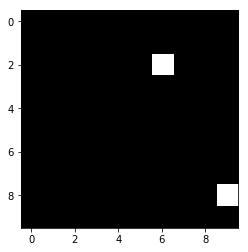

In [18]:
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works, using more of a policy gradient strategy.

In [7]:
a = [1,2,3]
a[1:]

[2, 3]